In [ ]:
#https://www.kaggle.com/code/tanyildizderya/airline-passenger-lstm

In [165]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT
# Any results you write to the current directory are saved as output.

patience = 25
sp = 12
timestamp= 10

In [166]:
df = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])
# productNumber = "12141"
# datasetTarget="/home/esteban/Documents/Optimix/DeepAR/tools/correctedsupplyProduct_"+productNumber+".csv"
# df = pd.read_csv(datasetTarget, header=0, index_col=0)
# df.reset_index(inplace=True)
# df.head()

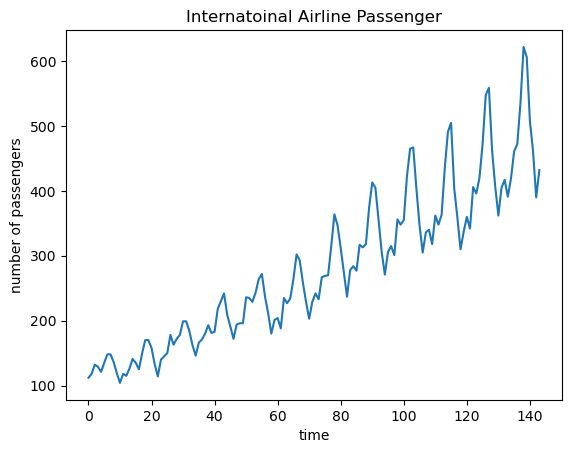

In [167]:
dataset = df.iloc[:,1].values
plt.plot(dataset)
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.title('Internatoinal Airline Passenger')
plt.show()

In [168]:
dataset = dataset.reshape(-1,1)
dataset = dataset.astype('float32')
dataset.shape
test = dataset.reshape(1,-1)[0][78:]
# print(test)

In [169]:
usePipe = True

if (usePipe):
    pipe = TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
    #         ("differencer", Differencer(lags=12, na_handling='fill_zero')),
    #     ("forecaster", NaiveForecaster(strategy="drift")),
    ])
    dataset = pipe.fit_transform(dataset)
    
else:
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)

#Is scaling train + test dataset introducing bias ? 

In [170]:
train_size = int(len(dataset)*0.50)
test_size = len(dataset) - train_size
train = dataset[:train_size,:]
test = dataset[train_size:len(dataset),:]
print('train_size : {}, test_size : {}, total_size : {}'.format(len(train),len(test),len(dataset)))

train_size : 72, test_size : 72, total_size : 144


In [171]:

dataX = []
dataY = []
for i in range(len(train)-timestamp-1):
    a = train[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(train[i+timestamp,0])
trainX = np.array(dataX)
trainY = np.array(dataY)

dataX = []
dataY = []
for i in range(len(test)-timestamp-1):
    a = test[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(test[i+timestamp,0])
testX = np.array(dataX)
testY = np.array(dataY)

# print(testX, testY)

In [172]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1])) #(number of points, features number, lookback)
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

print('trainX shape : {}, testX shape : {}'.format(trainX.shape,testX.shape))
print('trainY shape : {}, testY shape : {}'.format(trainY.shape,testY.shape))
#X shape (number of points, number of features, lookback)
#Y shape (number of points, 1)

trainX shape : (61, 1, 10), testX shape : (61, 1, 10)
trainY shape : (61,), testY shape : (61,)


Train on 61 samples, validate on 61 samples
Epoch 1/500
58/61 [===========================>..] - ETA: 0s - loss: 0.0794

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


61/61 [==============================] - 1s 6ms/sample - loss: 0.0781 - val_loss: 0.3074
Epoch 2/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0589 - val_loss: 0.2273
Epoch 3/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0428 - val_loss: 0.1572
Epoch 4/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0296 - val_loss: 0.1054
Epoch 5/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0202 - val_loss: 0.0637
Epoch 6/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0135 - val_loss: 0.0382
Epoch 7/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0093 - val_loss: 0.0239
Epoch 8/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0072 - val_loss: 0.0166
Epoch 9/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0062 - val_loss: 0.0123
Epoch 10/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0058 - val_loss: 0.0108
E

61/61 [==============================] - 0s 3ms/sample - loss: 0.0029 - val_loss: 0.0038
Epoch 82/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0029 - val_loss: 0.0038
Epoch 83/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0029 - val_loss: 0.0037
Epoch 84/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0028 - val_loss: 0.0040
Epoch 85/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0028 - val_loss: 0.0036
Epoch 86/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0028 - val_loss: 0.0037
Epoch 87/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0027 - val_loss: 0.0034
Epoch 88/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0028 - val_loss: 0.0036
Epoch 89/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0027 - val_loss: 0.0034
Epoch 90/500
61/61 [==============================] - 0s 2ms/sample - loss: 0.0027 - val_loss: 

Epoch 161/500
61/61 [==============================] - 0s 3ms/sample - loss: 0.0021 - val_loss: 0.0033


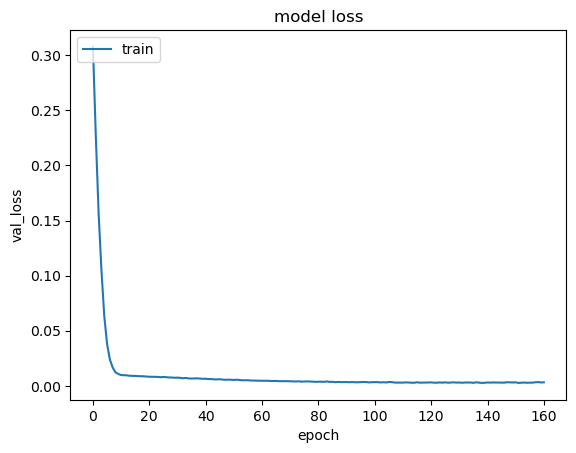

In [173]:
# model
model = Sequential()
model.add(Dense(32))
# model.add(LSTM(32, input_shape=(1, timestamp))) # 10 lstm neuron(block)
model.add(LSTM(32)) # 10 lstm neuron(block)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)) #'adam'
# history = model.fit(trainX, trainY, epochs=50, batch_size=1)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.0001)
]
history = model.fit(trainX, trainY, epochs=500, batch_size=1, validation_data=(testX,testY), callbacks=callbacks)
tf.keras.utils.plot_model(model, show_shapes=True)
plt.title('model loss')
try :
    plt.plot(history.history['val_loss'])
    plt.ylabel('val_loss')
except : 
    plt.plot(history.history['loss'])
    plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [174]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# print(trainX.ravel())
print(trainX)
# print(trainPredict.ravel())
# print (testPredict)
if usePipe :
    trainPredict = pipe.inverse_transform(trainPredict)
#     print(trainPredict)
#     print(trainPredict.shape,np.array([trainY]).reshape(-1,1).shape)
#     print(np.array([trainY]).reshape(-1,1))
    trainY = pipe.inverse_transform(np.array([trainY]).reshape(-1,1))
#     print(trainY)
    testPredict = pipe.inverse_transform(testPredict)
    testY = pipe.inverse_transform(np.array([testY]).reshape(-1,1))

else :
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

[[[0.03639082 0.06225729 0.11850993 0.10689918 0.0747727  0.129898
   0.17688361 0.17688361 0.13364612 0.06645891]]

 [[0.06225729 0.11850993 0.10689918 0.0747727  0.129898   0.17688361
   0.17688361 0.13364612 0.06645891 0.        ]]

 [[0.11850993 0.10689918 0.0747727  0.129898   0.17688361 0.17688361
   0.13364612 0.06645891 0.         0.06225729]]

 [[0.10689918 0.0747727  0.129898   0.17688361 0.17688361 0.13364612
   0.06645891 0.         0.06225729 0.0494678 ]]

 [[0.0747727  0.129898   0.17688361 0.17688361 0.13364612 0.06645891
   0.         0.06225729 0.0494678  0.09505606]]

 [[0.129898   0.17688361 0.17688361 0.13364612 0.06645891 0.
   0.06225729 0.0494678  0.09505606 0.15204183]]

 [[0.17688361 0.17688361 0.13364612 0.06645891 0.         0.06225729
   0.0494678  0.09505606 0.15204183 0.129898  ]]

 [[0.17688361 0.13364612 0.06645891 0.         0.06225729 0.0494678
   0.09505606 0.15204183 0.129898   0.09105495]]

 [[0.13364612 0.06645891 0.         0.06225729 0.0494678  0

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [175]:
if usePipe:
#     print(trainY,trainPredict)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    trainScore2 = math.sqrt(mean_absolute_percentage_error(trainY, trainPredict[:,0]))
    print('Train Score: %.2f MAPE' % (trainScore2))
    testScore2 = math.sqrt(mean_absolute_percentage_error(testY, testPredict[:,0]))
    print('Test Score: %.2f MAPE' % (testScore2))
else:
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    trainScore2 = math.sqrt(mean_absolute_percentage_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f MAPE' % (trainScore2))
    testScore2 = math.sqrt(mean_absolute_percentage_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f MAPE' % (testScore2))

Train Score: 16.15 RMSE
Test Score: 38.00 RMSE
Train Score: 0.27 MAPE
Test Score: 0.27 MAPE


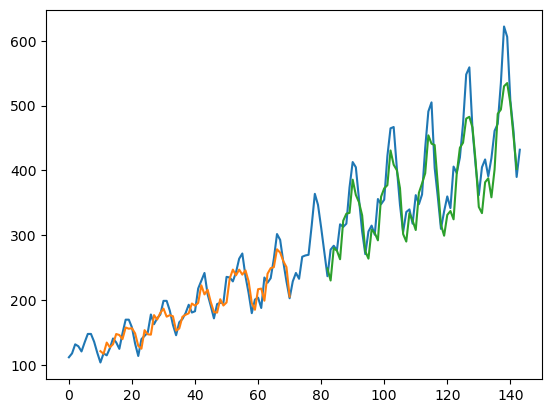

In [176]:
trainPredictPlot = np.empty_like(dataset)
# print(trainPredictPlot)
trainPredictPlot[:, :] = np.nan
# print(trainPredictPlot)
trainPredictPlot[timestamp:len(trainPredict)+timestamp, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(timestamp*2)+1:len(dataset)-1, :] = testPredict

# print(trainPredictPlot)
if usePipe:
    plt.plot(pipe.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
else:
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [177]:
from keras2cpp import export_model
export_model(model, 'KerasTestModel.model')

ADF Statistic: -3.0824733206804718
n_lags: 0.027877724852991947
p-value: 0.027877724852991947
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


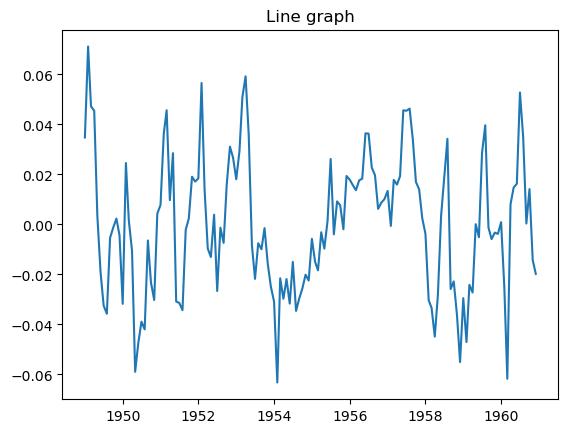

In [163]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])
pipe = TransformerPipeline(steps=[
        ("imputer", Imputer(method="mean")),
        ("boxcox", BoxCoxTransformer()),
        ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
        ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#         ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#     ("forecaster", NaiveForecaster(strategy="drift")),
])
tdf = pipe.fit_transform(df["Passengers"])
result = adfuller(tdf, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   
    
plt.title("Line graph")
plt.plot(df["Month"], tdf)
# plt.grid(which="both")
plt.show()